## Reconstruction and regularisation for a hyperspectral data set

Author: Ida Puggaard, DTU, s204211@dtu.dk

This notebook will be working with a hyperspectral dataset where 5 materials have been scanned. The materials are: Sugar, H2O2, H2O, Aluminium (10 mm), and PVC (7.8 mm). A picture from when the materials was scanned.



Data can be found at: https://doi.org/10.5281/zenodo.8307932  

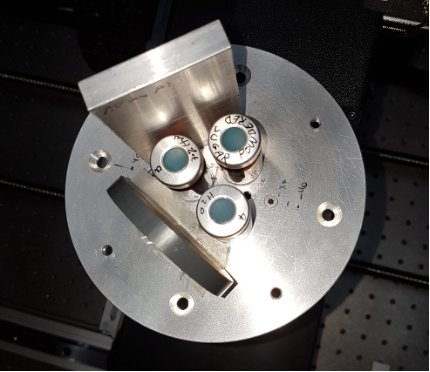

In [ ]:
import cil 
print(cil.__version__)

First import the used CIL add-ons

In [1]:
import numpy as np                 
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
import os

from cil.optimisation.algorithms import GD, FISTA, PDHG, CGLS, SIRT
from cil.optimisation.functions import LeastSquares, TotalVariation, L2NormSquared, MixedL21Norm, IndicatorBox, BlockFunction
from cil.io import TIFFWriter, TIFFStackReader
from cil.framework import AcquisitionGeometry
from cil.processors import CentreOfRotationCorrector, Slicer, \
    Binner, Masker, MaskGenerator, TransmissionAbsorptionConverter, RingRemover

from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

from mpl_toolkits.axes_grid1 import AxesGrid
from cil.plugins.ccpi_regularisation.functions import FGP_TV

astropy module not found


Define the scan geometry

In [ ]:
#detector parameters
ndet=256                                 # Number of detector pixels, excluding gaps
nElem=2                                  # Number of detector modules
pixel_size=0.077                         # Pixels' size (Pitch)

Sep=0.153                                # Pixels' gap length (cm)
det_space=(ndet)*pixel_size+Sep          # Size of detector in cm (pixels*pixel_size), including the gap

# acquisition parameters
range_angle=360                          # Angular span of projections
nproj=370                                # Number of projections
SDD=115.0                                # Source-Detector distance
sourceCentShift=0                        # Vertical source shift from perfect placement
detectCentShift=0                        # Vertical detector shift from perfect placement
SAD=57.5                                 # Source-AxisOfRotation distance

rot_axis_x = 0                           # x-position of AxisOfRotation
rot_axis_y = 0.0                         # y-position of AxisOfRotation


# Define acquisition geometry
ag = AcquisitionGeometry.create_Cone2D(
    source_position=[sourceCentShift, -SAD],
    detector_position=[detectCentShift, SDD-SAD],
    rotation_axis_position=[rot_axis_x, rot_axis_y])
ag.set_angles(angles=((np.linspace(range_angle,0,nproj, endpoint=False))), angle_unit='degree')
ag.set_panel(num_pixels=[ndet, 1], pixel_size=[pixel_size, pixel_size])
ag.set_channels(128) # Set energy channels
ag.set_labels(['angle', 'horizontal', 'channel'])


Look at the geometry

In [ ]:
show_geometry(ag)

Load the sinogram data from the sinogram. The sinogram have already been preprossed removing dead/hot pixels and dealing with gaps in the detector.

In [ ]:
# Load sinogram using h5 reader
f = h5py.File('sino25_interpol_line.h5','r') 
data_set = np.array(f["data"][:])  

# The sinograms have been preprossed and more pixels have been added to compensate 
# for a gap in the detector. So the panel size have to ce increased.
ag.set_panel(num_pixels=[ndet+2, 1], pixel_size=[pixel_size, pixel_size])

# Change labels to astra ordering.
ag.set_labels(['channel', 'angle', 'horizontal'])

# Look at the data dimensions <channel><angle><horizontal>
print(data_set.shape)

Putting the data into the CIL class and linking it with the definede geometry.

In [ ]:
data = ag.allocate() #allocate space
data.fill(data_set)

# Look at the data info
print(data)

Obtaining the image geometry

In [ ]:
ig=ag.get_ImageGeometry()

# Look at the image geometry info
print(ig)

Look at the sinogram for one channel at a time

In [ ]:
show2D(data.get_slice(channel=64))

Show the sinograms using the islice function; They are all scaled in the same range. So lower channel sinograms appear brighter than the ones with higher energy levels. This is because the materials have higher attenuation coefficients for lower energy channels. 

In [ ]:
islicer(data)

The attenuation coefficients for the 5 materials can be found using the python library: 'XRay DB' in the energy span: 20.21-153.53 KeV.In the plot glass is also included since Sugar, H2O2, and H2O are contained inside glass bottles.

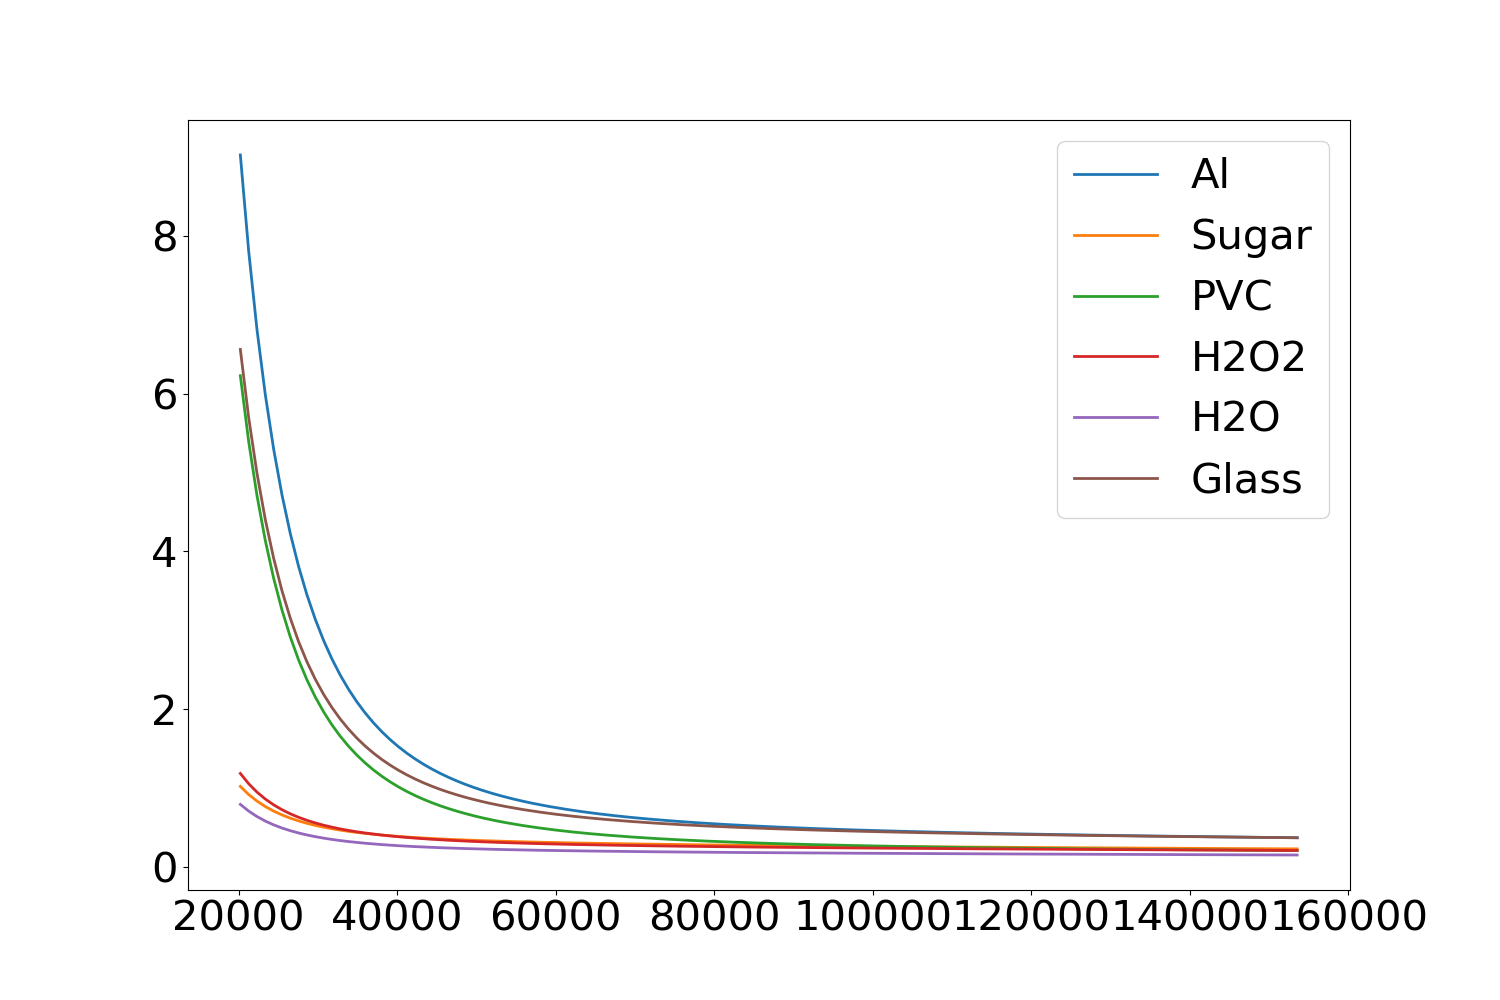

Firstly do we try to reconstruct the channels separately with TV regularisation. We will use the 
CIL function TotalVariation. 
$$argmin_{x} \frac{1}{2} ||Ax-b||_{2}^{2}+\alpha TV(x)$$

In [ ]:
# Allocate space for solution
recon_data=ig.allocate()

# Define projection operator
ag2D=ag.get_slice(channel=0)
ig2D=ag2D.get_ImageGeometry()
A_2D = ProjectionOperator(ig2D, ag2D, 'gpu')

# Loop over all the channels and reconstruct each channel 
for j in range(ig.channels):
    f1 = LeastSquares(A_2D, data.get_slice(channel=j))
    alpha=0.001
    # Totalvariation with non-negative constraint
    TV = alpha*TotalVariation(lower=0)

    myFISTATV_TV = FISTA(f=f1, 
            g=TV, 
            initial=ig2D.allocate(0),
            max_iteration=100, 
            update_objective_interval = 10)
    
    myFISTATV_TV.run(100,verbrose=1)
    recon_data.fill(myFISTATV_TV.solution,channel=j)


We can then look at the reconstruction.

In [ ]:
show2D(recon_data.get_slice(channel=63))

We can construct the energy curves from the 5 materials by extracting one pixel from each material and plot the cuvres. 

In [ ]:
solution_arr=recon_data.as_array()
plt.plot(solution_arr[:,50,125],'r',label='Alu')
plt.plot(solution_arr[:,125,150],'m',label='H2O2')
plt.plot(solution_arr[:,200,140],'g',label='pvc')
plt.plot(solution_arr[:,100,100],'c',label='Sugar')
plt.plot(solution_arr[:,160,100],'b',label='Water')

plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('Attenuation [1/cm]')
extent=np.linspace(21.20,153.53,8)
extent = ["%.2f" % v for v in extent]
plt.xticks(ticks=np.linspace(0,127,8),labels=extent)
plt.show()

We can also use TV regularisation in both the space and the energy dimension by giving the input 'SpaceChannels' to the TotalVariation function. 

In [30]:
A = ProjectionOperator(ig, ag, 'gpu')
f1 = LeastSquares(A, data)

alpha = 0.001
GTV = alpha*TotalVariation(correlation='SpaceChannels',lower=0)

myFISTATV = FISTA(f=f1, 
                  g=GTV, 
                  initial=ig.allocate(0),
                  max_iteration=100, 
                  update_objective_interval = 10)


myFISTATV.run(100,verbrose=1)

Look at the solution.

In [ ]:
show2D(myFISTATV.solution.get_slice(channel=63))

We can again look at the energy curves and see that the regularisation have had an effect on the curves.

In [ ]:
solution_arr=myFISTATV.solution.as_array()
plt.plot(solution_arr[:,50,125],'r',label='Alu')
plt.plot(solution_arr[:,125,150],'m',label='H2O2')
plt.plot(solution_arr[:,200,140],'g',label='pvc')
plt.plot(solution_arr[:,100,100],'c',label='Sugar')
plt.plot(solution_arr[:,160,100],'b',label='Water')

plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('Attenuation [1/cm]')
extent=np.linspace(21.20,153.53,8)
extent = ["%.2f" % v for v in extent]
plt.xticks(ticks=np.linspace(0,127,8),labels=extent)
plt.show()


The regularisation used in the space dimension and the energy dimension does not have to be the same. We can therefor try to use Tikhonov regularisation in the energy dimension instead of TV.
The reasoning is that Tikhonov is good for smoothing compared to TV which is good for maintaining sharp edges. 

$$argmin_{x} \frac{1}{2} ||Ax-b||_{2}^{2}+\alpha TV(x)+\beta || \mathbf{D}_e x ||$$

$ \beta $ is the regularisation parameter for Tikhonov

In [ ]:
# Use same alpha 
alpha = 0.001 

beta = 0.5

# Projection operationer
A = ProjectionOperator(ig, ag, 'gpu')

# Use the gradient operator to apply the regularisation and plitting it to use different 
# regularisation terms 
Grad2 = GradientOperator(ig, correlation='SpaceChannels',split=True)   
K = BlockOperator(A, Grad2)
splitTik_TV=BlockFunction(beta*0.5*L2NormSquared(), alpha*MixedL21Norm())
f = BlockFunction(0.5*L2NormSquared(b=data),splitTik_TV)
# Non-negative constraint
G = IndicatorBox(lower=0 )

# Use PDHG as solver
num_iter=100
PDHG_Tik_TV = PDHG(f=f, g=G, operator=K, max_iteration=num_iter, update_objective_interval = 10)

PDHG_Tik_TV.run(num_iter,verbose=2)




Show the solution for each channel.

In [ ]:
show2D(PDHG_Tik_TV.solution.get_slice(channel=63))

We can once again look at the energy curves for each material.

In [ ]:
Tik_TV_sol=PDHG_Tik_TV.solution.as_array()

plt.plot(Tik_TV_sol[:,50,125],'r',label='Alu')
plt.plot(Tik_TV_sol[:,125,150],'m',label='H2O2')
plt.plot(Tik_TV_sol[:,200,140],'g',label='pvc')
plt.plot(Tik_TV_sol[:,100,100],'c',label='Sugar')
plt.plot(Tik_TV_sol[:,160,100],'b',label='Water')

plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('Attenuation [1/cm]')
extent=np.linspace(21.20,153.53,8)
extent = ["%.2f" % v for v in extent]
plt.xticks(ticks=np.linspace(0,127,8),labels=extent)
plt.show()

It can be seen that the energy curves looks more smooth and closer to the table value curves from xraydb.  